In [6]:
from shapely.geometry import Point, Polygon
import geopandas as gpd
import pandas as pd
import folium
import geojson

In [56]:
posters = pd.read_csv('./dummy/p.csv')

posters['ID'] = posters['ID'].apply(lambda x : 'P' + str(x))

posters = posters.set_index('ID')

geometry = [Point(lon,lat) for lon, lat in zip(posters['longitude'], posters['latitude'] )]

posters_gdf = gpd.GeoDataFrame(posters, geometry=geometry,crs='EPSG:4326' )

posters_gdf = posters_gdf.to_crs("epsg:31370")

posters_gdf.head()



,latitude,longitude,geometry
ID,,,
P22,51.278824,4.409519,POINT (152844.191 218773.503)
P49,51.182657,4.372914,POINT (150290.660 208073.635)
P65,51.185132,4.344203,POINT (148283.183 208349.244)
P77,51.171207,4.364278,POINT (149686.737 206799.787)
P78,51.171212,4.364441,POINT (149698.166 206800.342)


In [46]:
with open('./dummy/test_geo.geojson', 'r') as f:
    gj = geojson.load(f)

gj.is_valid

gj


{"bbox": [4.339824, 51.181978, 4.502609, 51.29985], "features": [{"geometry": {"coordinates": [[[4.339824, 51.248737], [4.340451, 51.248408], [4.343983, 51.246483], [4.346526, 51.245097], [4.352176, 51.242434], [4.352568, 51.242262], [4.35402, 51.241756], [4.359701, 51.242208], [4.364392, 51.242165], [4.373556, 51.242078], [4.377583, 51.240024], [4.378325, 51.240062], [4.383114, 51.241965], [4.385685, 51.242194], [4.389668, 51.241654], [4.393454, 51.241068], [4.396203, 51.240497], [4.395849, 51.228925], [4.391844, 51.228999], [4.388357, 51.229045], [4.38487, 51.22909], [4.384865, 51.22909], [4.383945, 51.2291], [4.383907, 51.225501], [4.392369, 51.21758], [4.393633, 51.215162], [4.393943, 51.215045], [4.395309, 51.215502], [4.403291, 51.218089], [4.405392, 51.218239], [4.415057, 51.21493], [4.420493, 51.208673], [4.415214, 51.200288], [4.410469, 51.194409], [4.403821, 51.19385], [4.400582, 51.194868], [4.39705, 51.196159], [4.394379, 51.197193], [4.38989, 51.198751], [4.389512, 51.1988

In [55]:
poi = gpd.read_file("./dummy/test_geo.geojson",crs='EPSG:4326').set_index('name')
poi = poi.to_crs("epsg:31370")

poi

,group_index,value,geometry
name,,,
Meir,0,600.0,"POLYGON ((147979.713 215425.694, 148023.479 21..."


In [60]:
dt = Polygon(gj['features'][0]['geometry']['coordinates'][0])
dt_lon, dt_lat = gj['features'][0]['properties']['center']
map = folium.Map(location=(dt_lat,dt_lon), tiles="cartodbpositron", min_zoom=11)

folium.Marker((dt_lat,dt_lon)).add_to(map)

for index,row in posters_gdf.iterrows():
    lon = row['longitude']
    lat = row['latitude']
    point = Point(lon,lat)

    if point.within(dt) or point.touches(dt):
        folium.Marker(location= [lat, lon],popup=index, icon= folium.Icon(color='red', icon='star') ).add_to(map)
        folium.Circle([lat, lon],radius=300, color='red', fill_color = 'red').add_to(map)

    else:
        folium.Marker(location= [lat, lon],popup=index, icon= folium.Icon(color='cadetblue', icon='star') ).add_to(map)


folium.features.GeoJson(gj).add_to(map)

map

In [54]:
distances = posters_gdf.geometry.distance(poi.loc['Meir'].geometry.centroid)

distances

ID
P22     4392.847213
P49     7223.795326
P65     8144.531003
P77     8632.413088
P78     8626.653746
           ...     
P655    4650.372728
P361    4921.374554
P929    3886.850563
P681    5169.673976
P256    4988.926952
Length: 111, dtype: float64

In [57]:
buffer = posters_gdf.geometry.buffer(300)

buffer


ID
P22     POLYGON ((153144.191 218773.503, 153142.747 21...
P49     POLYGON ((150590.660 208073.635, 150589.215 20...
P65     POLYGON ((148583.183 208349.244, 148581.738 20...
P77     POLYGON ((149986.737 206799.787, 149985.293 20...
P78     POLYGON ((149998.166 206800.342, 149996.721 20...
                              ...                        
P655    POLYGON ((149870.786 212260.899, 149869.342 21...
P361    POLYGON ((153069.782 209620.255, 153068.338 20...
P929    POLYGON ((150971.062 211984.912, 150969.617 21...
P681    POLYGON ((158691.723 212356.088, 158690.278 21...
P256    POLYGON ((153816.385 209472.190, 153814.940 20...
Length: 111, dtype: geometry

In [61]:
folium.features.GeoJson(buffer.to_crs(epsg=4324)).add_to(map)

map

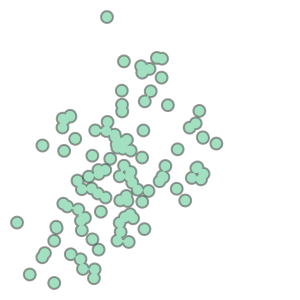

In [59]:
buffer_union = buffer.geometry.unary_union
buffer_union